In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/My Drive/OriGen
# !ls /

/content/drive/My Drive/OriGen
bin			    datalab  lib     media		       proc	   sbin  tools
boot			    dev      lib32   mnt		       python-apt  srv	 usr
content			    etc      lib64   NGC-DL-CONTAINER-LICENSE  root	   sys	 var
cuda-keyring_1.0-1_all.deb  home     libx32  opt		       run	   tmp


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

In [ ]:
data       = np.load('Data.npy',allow_pickle=True)
dict_data  = data.item()
pressure   = dict_data['pressure']
u_velocity = dict_data['u_velocity']
v_velocity = dict_data['v_velocity']
x_coordinate = dict_data['x']
y_coordinate = dict_data['y']

Re = 100 # Reynolds Number
batch_size = 25  # Define batch size
num_selected_points = 100
num_epochs = 300


class Data_Loader(Dataset):
    def __init__(self, x, y, pressure, u_velocity, v_velocity):
        self.inputs = torch.tensor(np.column_stack((x, y)), dtype=torch.float32)
        self.outputs = torch.tensor(np.column_stack((u_velocity, v_velocity, pressure)), dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

# Exclude boundary points and randomly select 100 points
inner_data = np.stack([arr[1:-1, 1:-1].flatten() for arr in [x_coordinate, y_coordinate, pressure, u_velocity, v_velocity]], axis=1)
selected_indices = np.random.choice(inner_data.shape[0], num_selected_points, replace=False)
selected_data = inner_data[selected_indices]

# Split the data into training and validation sets (90% train, 10% validate)
train_size = int(0.9 * num_selected_points)
train_data, valid_data = selected_data[:train_size], selected_data[train_size:]

train_x, train_y, train_pressure, train_u_velocity, train_v_velocity = train_data.T
valid_x, valid_y, valid_pressure, valid_u_velocity, valid_v_velocity = valid_data.T

# Create dataset objects for training and validation
train_dataset = Data_Loader(train_x, train_y, train_pressure, train_u_velocity, train_v_velocity)
valid_dataset = Data_Loader(valid_x, valid_y, valid_pressure, valid_u_velocity, valid_v_velocity)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define neural network architecture
class SteadyStatePINN(nn.Module):
    def __init__(self):
        super(SteadyStatePINN, self).__init__()
        self.fc1 = nn.Linear(2, 50) # Input dimensions: x, y
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3) # Output dimensions: u, v, p

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)

# Instantiate the model
model = SteadyStatePINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
def navier_stokes_residuals(model, coordinates, Re):
    '''
    input: Coordinate: x, y
           Re: Reynolds Number
    Output: Residual of continuity equation, momentum residue in x direction, momnentum residue in y direction
    '''
    coordinates.requires_grad = True

    # Forward pass to get the predictions for u, v, and p
    uvp = model(coordinates)
    u = uvp[:, 0]
    v = uvp[:, 1]
    p = uvp[:, 2]

    # Compute gradients
    grad_u = torch.autograd.grad(u, coordinates, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    grad_v = torch.autograd.grad(v, coordinates, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    grad_p = torch.autograd.grad(p, coordinates, grad_outputs=torch.ones_like(p), create_graph=True, retain_graph=True)[0]

    # Correct computation of derivatives
    # Note: torch.div(grad_u[:, 0], coordinates[:, 0]) is not correct for computing second derivatives.
    # You need to directly compute the second derivatives for the Laplacian.
    du_dx = grad_u[:, 0]
    du_dy = grad_u[:, 1]
    dv_dx = grad_v[:, 0]
    dv_dy = grad_v[:, 1]

    # Compute second derivatives for the viscous terms
    laplacian_u = torch.autograd.grad(du_dx, coordinates, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0] + \
                  torch.autograd.grad(du_dy, coordinates, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1]

    laplacian_v = torch.autograd.grad(dv_dx, coordinates, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 0] + \
                  torch.autograd.grad(dv_dy, coordinates, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 1]

    # Continuity equation residual (incompressibility condition)
    continuity_residual = du_dx + dv_dy

    # Momentum equation residuals
    momentum_u_residual = du_dx * u + du_dy * v + grad_p[:, 0] - (1/Re) * laplacian_u
    momentum_v_residual = dv_dx * u + dv_dy * v + grad_p[:, 1] - (1/Re) * laplacian_v

    return continuity_residual, momentum_u_residual, momentum_v_residual



In [ ]:
def boundary_loss(model):
    # Predictions for the interior points
    array = np.zeros((50, 2))
    array[:, 0] = np.linspace(0, 1, 50)
    y_0boundary = torch.tensor(array, dtype=torch.float32, requires_grad=True)
    array = np.zeros((50, 2)) +1.0
    array[:, 0] = np.linspace(0, 1, 50)
    y_1boundary = torch.tensor(array, dtype=torch.float32, requires_grad=True)
    array = np.zeros((50, 2))
    array[:, 1] = np.linspace(0, 1, 50)
    x_0boundary = torch.tensor(array, dtype=torch.float32, requires_grad=True)
    array = np.zeros((50, 2)) +1.0
    array[:, 1] = np.linspace(0, 1, 50)
    x_1boundary = torch.tensor(array, dtype=torch.float32, requires_grad=True)

    y_0boundary_predictions = model(y_0boundary)
    y_1boundary_predictions = model(y_1boundary)
    x_0boundary_predictions = model(x_0boundary)
    x_1boundary_predictions = model(x_1boundary)

    # Dirichlet boundary conditions
    u_boundary_predictions = y_1boundary_predictions[:, 0]
    v_boundary_predictions = y_1boundary_predictions[:, 1]
    p_boundary_predictions = y_1boundary_predictions[:, 2]
    y1_dirichlet_loss = torch.mean((u_boundary_predictions - 1) ** 2)+torch.mean((v_boundary_predictions) ** 2) +torch.mean((p_boundary_predictions) ** 2)
    u_boundary_predictions = y_0boundary_predictions[:, 0]
    v_boundary_predictions = y_0boundary_predictions[:, 1]
    y0_dirichlet_loss = torch.mean((u_boundary_predictions) ** 2)+torch.mean((v_boundary_predictions) ** 2)
    u_boundary_predictions = x_0boundary_predictions[:, 0]
    v_boundary_predictions = x_0boundary_predictions[:, 1]
    x0_dirichlet_loss = torch.mean((u_boundary_predictions) ** 2)+torch.mean((v_boundary_predictions) ** 2)
    u_boundary_predictions = x_1boundary_predictions[:, 0]
    v_boundary_predictions = x_1boundary_predictions[:, 1]
    x1_dirichlet_loss = torch.mean((u_boundary_predictions) ** 2)+torch.mean((v_boundary_predictions) ** 2)
    total_dirichlet_loss = x0_dirichlet_loss + x1_dirichlet_loss + y0_dirichlet_loss + y1_dirichlet_loss

    # Neumann boundary conditions
    p_boundary_predictions = y_0boundary_predictions[:, 2]
    neumann_predictions_grad = torch.autograd.grad(p_boundary_predictions.sum(), y_0boundary, create_graph=True)[0]
    y0_neumann_loss = torch.mean((neumann_predictions_grad ) ** 2)
    p_boundary_predictions = x_0boundary_predictions[:, 2]
    neumann_predictions_grad = torch.autograd.grad(p_boundary_predictions.sum(), x_0boundary, create_graph=True)[0]
    x0_neumann_loss = torch.mean((neumann_predictions_grad ) ** 2)
    p_boundary_predictions = x_1boundary_predictions[:, 2]
    neumann_predictions_grad = torch.autograd.grad(p_boundary_predictions.sum(), x_1boundary, create_graph=True)[0]
    x1_neumann_loss = torch.mean((neumann_predictions_grad ) ** 2)
    total_neumann_loss = x0_neumann_loss + x1_neumann_loss + y0_neumann_loss

    # Total loss
    total_loss =  total_dirichlet_loss + total_neumann_loss
    return total_loss

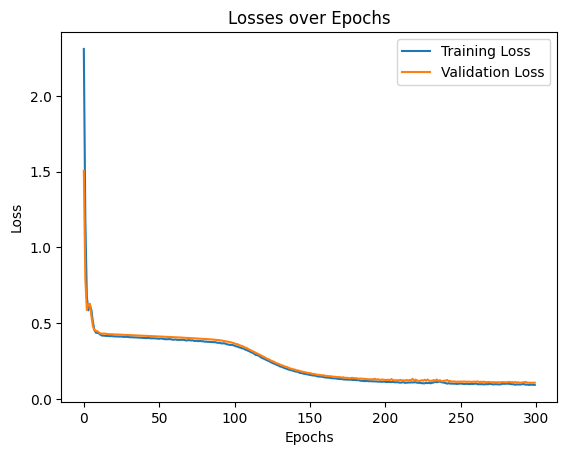

In [ ]:
def train(model, train_loader, optimizer, loss_function):
    model.train()  # Set the model to training mode
    total_loss_accumulated = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        # Physics-informed loss
        continuity_res, momentum_u_res, momentum_v_res = navier_stokes_residuals(model, inputs, Re)
        physics_loss = torch.mean(continuity_res ** 2) + torch.mean(momentum_u_res ** 2) + torch.mean(momentum_v_res ** 2)
        total_boundary_loss = boundary_loss(model)
        # MSE loss
        MSE_loss = loss_function(outputs, targets)
        # Total loss
        total_loss = physics_loss + total_boundary_loss + MSE_loss
        total_loss.backward()
        optimizer.step()
        total_loss_accumulated += total_loss.item()
    average_loss = total_loss_accumulated / len(train_loader)
    return average_loss

def validate(model, valid_loader, loss_function):
    model.eval()  # Set the model to evaluation mode
    total_loss_accumulated = 0.0
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs.requires_grad_(True)
            outputs = model(inputs)
            # Physics-informed loss
            with torch.enable_grad():
                continuity_res, momentum_u_res, momentum_v_res = navier_stokes_residuals(model, inputs, Re)
                physics_loss = torch.mean(continuity_res ** 2) + torch.mean(momentum_u_res ** 2) + torch.mean(momentum_v_res ** 2)
                total_boundary_loss = boundary_loss(model)
            # MSE loss
            MSE_loss = loss_function(outputs, targets)
            # Total loss
            total_loss = physics_loss + total_boundary_loss + MSE_loss
            total_loss_accumulated += total_loss.item()
    average_loss = total_loss_accumulated / len(valid_loader)
    return average_loss
loss_function = nn.MSELoss()

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, loss_function)
    valid_loss = validate(model, valid_loader, loss_function)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

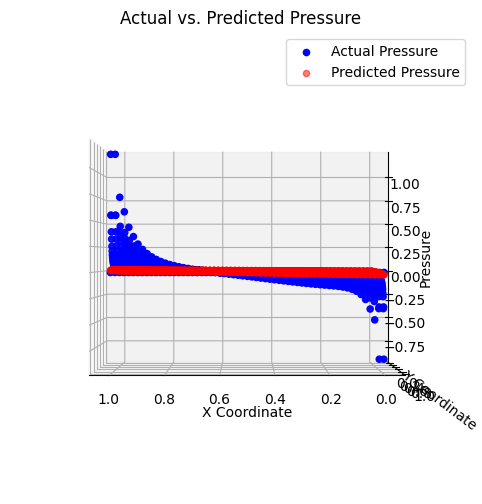

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# Plotting
x_coordinate_flatten = x_coordinate.flatten().astype(np.float32)
y_coordinate_flatten = y_coordinate.flatten().astype(np.float32)
pressure_flatten     = pressure.flatten().astype(np.float32)
u_velocity = u_velocity.flatten().astype(np.float32)
v_velocity = v_velocity.flatten().astype(np.float32)
combined_array = torch.tensor(np.column_stack((x_coordinate_flatten, y_coordinate_flatten)))
uvp = model(combined_array)
predicted_u = uvp[:, 0].detach().numpy()
predicted_v = uvp[:, 1].detach().numpy()
predicted_pressure = uvp[:, 2].detach().numpy()

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot actual training data
ax.scatter(x_coordinate_flatten, y_coordinate_flatten, pressure_flatten, color='b', label='Actual Pressure')

# Plot predicted pressure
ax.scatter(x_coordinate_flatten, y_coordinate_flatten, predicted_pressure, color='r', alpha=0.5, label='Predicted Pressure')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Pressure')
ax.set_title('Actual vs. Predicted Pressure')
# Set viewing angle
elevation_angle = 0  # Angle in degrees to the z-axis
azimuth_angle = 90    # Angle in degrees to the x,y-plane
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()

plt.show()

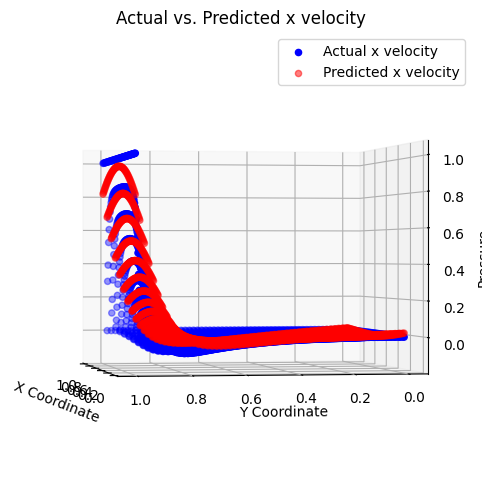

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot actual training data
ax.scatter(x_coordinate_flatten, y_coordinate_flatten, u_velocity, color='b', label='Actual x velocity')

# Plot predicted pressure
ax.scatter(x_coordinate_flatten, y_coordinate_flatten, predicted_u, color='r', alpha=0.5, label='Predicted x velocity')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Pressure')
ax.set_title('Actual vs. Predicted x velocity')
# Set viewing angle
elevation_angle = 0  # Angle in degrees to the z-axis
azimuth_angle = 170    # Angle in degrees to the x,y-plane
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()

plt.show()

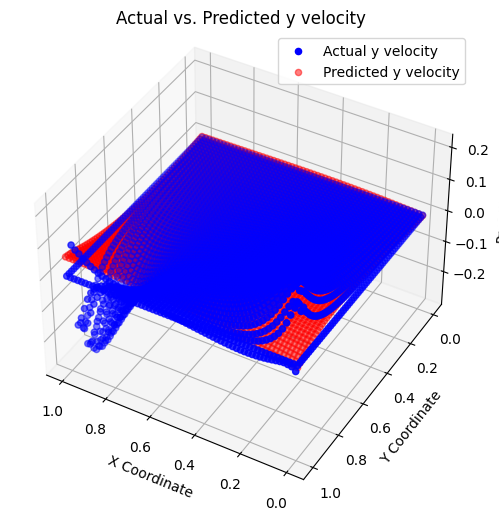

In [ ]:
# !pip install ipympl
# %matplotlib widget

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot actual training data
ax.scatter(x_coordinate_flatten, y_coordinate_flatten, v_velocity, color='b', label='Actual y velocity')

# Plot predicted pressure
ax.scatter(x_coordinate_flatten, y_coordinate_flatten, predicted_v, color='r', alpha=0.5, label='Predicted y velocity')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Pressure')
ax.set_title('Actual vs. Predicted y velocity')
# # Set viewing angle
elevation_angle = 40  # Angle in degrees to the z-axis
azimuth_angle = 120    # Angle in degrees to the x,y-plane
ax.view_init(elev=elevation_angle, azim=azimuth_angle)

ax.legend()

plt.show()